In [69]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif', size=12)

import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.data import StroopSRODataset, CogPonderDataModule, NBackSRODataset
from pathlib import Path

In [70]:
CHECKPOINT_PATH = Path('models/checkpoints/stroop/cogponder_epochs-309.ckpt')

In [71]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

print('loading data module...', end='')
dataset = StroopSRODataset(n_subjects=1, step_duration=20)
datamodule = CogPonderDataModule(dataset, num_workers=8)
datamodule.prepare_data()
print('Done!')

subject_ids, trial_ids, contexts, stimuli, y_human, rt_human, y_correct = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_pred, y_steps, p_halts, rt_pred = model_ckpt(stimuli, subject_ids, contexts)

    print('Done!')

loading data module...['s531']
Done!
Predicting responses...Done!


In [72]:
human_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (stimuli[:,0, 0] == y_correct).float() * 100,
    'agent': 'Human data',
})

cogponder_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': (rt_pred * dataset.step_duration).float(),
    'accuracy': (stimuli[:,0, 0] == y_pred).float() * 100,
    'agent': 'CogPonder agent',
})

# human_stats['condition'] = human_stats['condition'].map({0: 'Incongruent', 1: 'Congruent'})

stats = pd.concat([human_stats, cogponder_stats]).reset_index()

mean_accuracy = stats.groupby(['agent', 'condition'])['accuracy'].mean()
median_rt = stats.groupby(['agent', 'condition'])['response_time'].median()

median_rt, mean_accuracy

(agent            condition  
 CogPonder agent  congruent      540.0
                  incongruent    580.0
 Human data       congruent      870.0
                  incongruent    980.0
 Name: response_time, dtype: float32,
 agent            condition  
 CogPonder agent  congruent      100.0
                  incongruent    100.0
 Human data       congruent      100.0
                  incongruent    100.0
 Name: accuracy, dtype: float32)

In [73]:
plot_data = stats.melt(
    id_vars=['condition', 'agent'],
    value_vars=['response_time', 'accuracy'],
    var_name='measure'
)

/home/morteza/micromamba/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


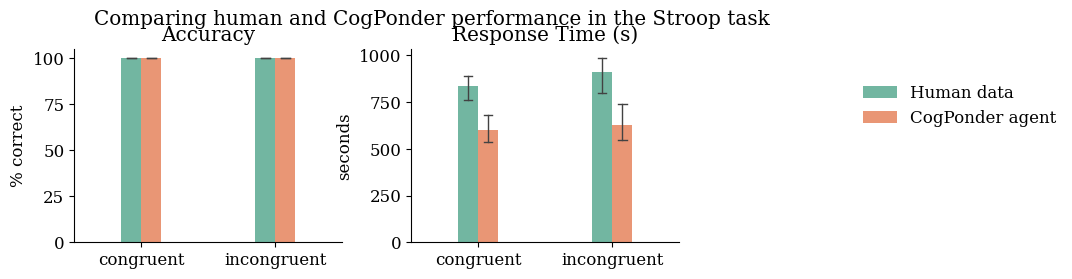

In [74]:

g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['congruent', 'incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

In [75]:
human_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (y_human == y_correct).float(),
    'agent': 'Human data',
})

cogponder_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_pred * dataset.step_duration,
    'accuracy': (y_pred == y_correct).float(),
    'agent': 'CogPonder agent'
})

plot_data = pd.concat([human_performance, cogponder_performance]).reset_index()

plot_data['condition'] = plot_data['condition'].map({0: 'Incongruent', 1: 'Congruent'})

plot_data = plot_data.melt(id_vars=['condition', 'agent'],
               value_vars=['response_time', 'accuracy'],
               var_name='measure'
               )

/home/morteza/micromamba/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_119775/1906628440.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


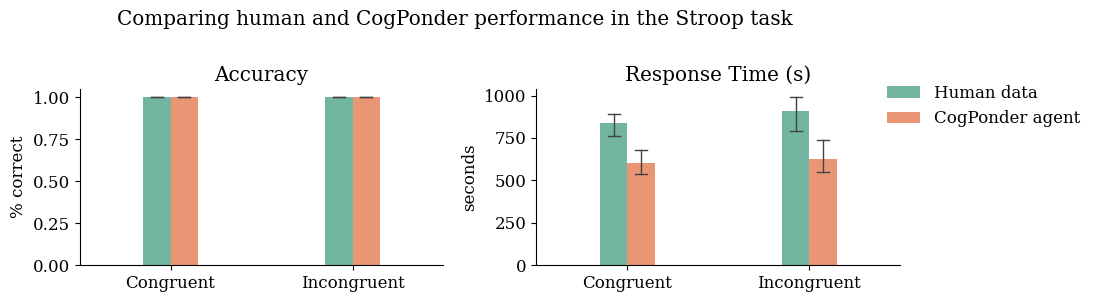

In [76]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['Congruent', 'Incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

/home/morteza/micromamba/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_119775/6315365.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


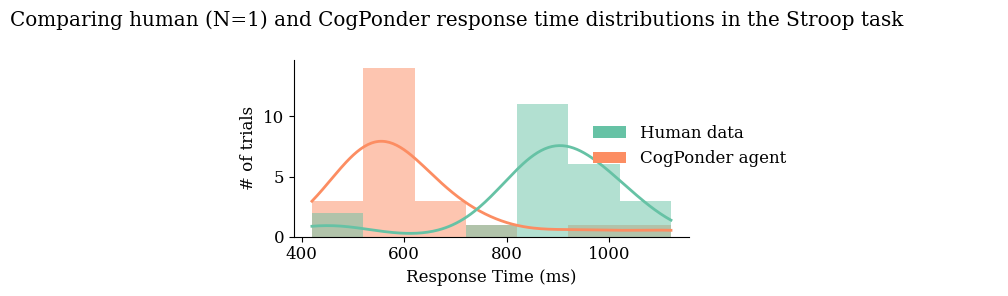

In [77]:
# Figure 4

plot_data = pd.DataFrame({
    'rt_human': rt_human * dataset.step_duration,
    'rt_pred': rt_pred * dataset.step_duration,
}).melt()

g = sns.displot(
    data=plot_data, x='value', hue='variable',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=1.2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    hue_order=['rt_human', 'rt_pred'],
    legend=True
)

# replace labels
g._legend.set_title(None)
g.legend.set_bbox_to_anchor((1.6, .5))
for t, l in zip(g._legend.texts, ['Human data', 'CogPonder agent']):
    t.set_text(l)

g._legend.legend_handles[0].set_alpha(1)
g._legend.legend_handles[1].set_alpha(1)

g.ax.set(xlabel='Response Time (ms)', ylabel='# of trials')

plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the Stroop task')
plt.tight_layout()
plt.savefig('outputs/figures/figure4-stroop.png', bbox_inches='tight', dpi=300)
plt.show()